### Cournot Duopoly

- There are two firms that interact in repeated Cournot duopoly game.
- Costs: c1=c2=0.5
- Demand: P = 1-Q
- Competition: Q=1/3, P=2/3, q=1/6
- Monopoly: Q=1/4, P=3/4, q=1/8


#### Cases:
- 2 Rl bots against each other
- 1 Rl bot vs copycat
- Rl bot trained with copycat against itself

### Import Packages

In [145]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Game 

In [318]:
def P(Q):
    return max(1-Q,0)
    
class firm:
    def __init__(self, c):
        self.c = c
    
    def profit(self,p,q):
        return (p-self.c)*q
    
    def bestresponse(self, q_other):
        return (1-q_other-self.c)/2 
    
def profit(q1,q2):
    return (P(q1+q2)-c1)*q1,(P(q1+q2)-c2)*q2

def competition(c1,c2):
    q1c = (1+c2-2*c1)/3
    q2c = (1+c1-2*c2)/3
    Qc = q1c + q2c
    Pc = P(Qc)
    return q1c, q2c, Pc, Qc

def monopoly(c1,c2):
    if c1<c2:
        Qm = (1-c1)/2
        Pm = (1+c1)/2
    if c1<=c2:
        Qm = (1-c2)/2
        Pm = (1+c2)/2
    return Qm,Pm

def gameReward(q1,q2):
    Q = q1 + q2
    p = P(Q)
    π1 = firm1.profit(p,q1)
    π2 = firm2.profit(p,q2)
    return (π1,π2)

def generateGame(c1, c2):
    firm1 = firm(c1)
    firm2 = firm(c2)
    q1c, q2c, Pc, Qc = competition(c1,c2)
    Qm,Pm = monopoly(c1,c2)
    return q1c, q2c, Pc, Qc, Qm, Pm, Qm/2

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

### Helper Functions

In [319]:
Transition = namedtuple('Transition',('state','next_state','action','reward'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [320]:
class DQN(nn.Module):
    # Takes in a vector of states and gives out valuations for each action
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)  

In [433]:
def getProbs(agent, BETA):
    return torch.exp(agent.policy_net(agent.state)/BETA)/torch.sum(torch.exp(agent.policy_net(agent.state)/BETA))

In [322]:
class Agent:
    def __init__(self, N_STATES, N_ACTIONS, N_MEMORY=10000, BATCH_SIZE=512, GAMMA=0, TAU = 0.0001, LR = 1e-5,
                 EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 1000, 
                 BETA_START = 0.1, BETA_END = 0.01, BETA_DECAY = 1000):
        self.N_STATES = N_STATES
        self.N_ACTIONS = N_ACTIONS
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.STEPS = 0
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.EPS_THRESHOLD = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*self.STEPS/EPS_DECAY)
        self.BETA_START = BETA_START
        self.BETA_END = BETA_END
        self.BETA_DECAY = BETA_DECAY
        self.BETA_THRESHOLD = BETA_END + (BETA_START-BETA_END)*math.exp(-1.*self.STEPS/BETA_DECAY)
        self.LR = LR
        self.TAU = TAU
        self.policy_net = DQN(N_STATES,N_ACTIONS)
        self.target_net = DQN(N_STATES,N_ACTIONS)
        self.state = torch.zeros(1,N_STATES)
        self.actions = torch.tensor(np.arange(N_ACTIONS))
        self.memory = ReplayMemory(N_MEMORY)
        self.optimizer = optim.AdamW(self.policy_net.parameters(),lr=LR,amsgrad=True)
        self.action_history = []
        self.loss = torch.tensor(1000)

In [434]:
def select_action(agent):
    # Given state selects action either from the DQN (Q values become probs) or randomly. 
    sample = random.random()
    agent.EPS_THRESHOLD = agent.EPS_END + (agent.EPS_START-agent.EPS_END)*math.exp(-1.*agent.STEPS/agent.EPS_DECAY)
    agent.BETA_THRESHOLD = agent.BETA_END + (agent.BETA_START-agent.BETA_END)*math.exp(-1.*agent.STEPS/agent.BETA_DECAY)
    agent.STEPS += 1

    if sample>agent.EPS_THRESHOLD:
        with torch.no_grad():
            probs = getProbs(agent, agent.BETA_THRESHOLD)     
            try: 
                index = probs.multinomial(num_samples=1, replacement=True)
                choice = agent.actions[index]
                return torch.tensor([[choice]],dtype=torch.long)
            except:
                try: 
                    return agent.policy_net(agent.state).max(1)[1].view(1,1) # pick up action with largest expected reward
                except:
                    return agent.policy_net(agent.state).max(0)[1].view(1,1) # pick up action with largest expected reward

    else:
        randchoice = random.choice(np.arange(agent.N_ACTIONS))
        return torch.tensor([[randchoice]],dtype=torch.long)

In [324]:
def update_target_net(agent):
    target_net_state_dict = agent.target_net.state_dict()
    policy_net_state_dict = agent.policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*agent.TAU+target_net_state_dict[key]*(1-agent.TAU)
    agent.target_net.load_state_dict(target_net_state_dict)

In [325]:
def optimize_model(agent):
    if len(agent.memory)<agent.BATCH_SIZE:
        return
    
    # Load data
    transitions = agent.memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch = torch.cat(batch.state)
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = agent.policy_net(state_batch).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(agent.BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = agent.target_net(non_final_next_states).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*agent.GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    agent.loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    agent.optimizer.zero_grad()
    agent.loss.backward()
    torch.nn.utils.clip_grad_value_(agent.policy_net.parameters(),100)
    agent.optimizer.step()   

In [388]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx] 

In [407]:
torch.set_printoptions(precision=2)

In [438]:
def track(agent, q1c):
    with torch.no_grad():
        test = torch.tensor([[q1c]], dtype = torch.float32)
        q = agent1.policy_net(test)
        print(f'Loss:{agent.loss.item()},BETA:{round(agent.BETA_THRESHOLD,2)},EPS:{round(agent.EPS_THRESHOLD,2)},P:{getProbs(agent,agent.BETA_THRESHOLD)},Q:{q}')
        

In [439]:
track(agent1,q1c)

Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.83, 0.17]]),Q:tensor([[ 0.04, -0.14]])


### Cournot Game

In [440]:
c1, c2 = 0.5,0.5
firm1 = firm(c1)
firm2 = firm(c2)
q1c, q2c, Pc, Qc, Qm, Pm, qm = generateGame(c1, c2)
print(q1c, q2c, Pc, Qc, Qm, Pm, qm)

0.16666666666666666 0.16666666666666666 0.6666666666666667 0.3333333333333333 0.25 0.75 0.125


In [441]:
gameReward(q1c,q1c), gameReward(qm,qm),  gameReward(q1c,qm), 

((0.2777777777777779, 0.2777777777777779),
 (0.3125, 0.3125),
 (0.3472222222222222, 0.26041666666666674))

In [442]:
N_ACTIONS = 2
Qgrid = np.linspace(qm, q1c, N_ACTIONS)
print(Qgrid)

[0.125      0.16666667]


### HyperParameters and Initializations

In [443]:
BATCH_SIZE = 512 # number of transitions sampled from replay buffer
GAMMA = 0.9 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
BETA_START = 0.1 # temperature of the greedy-exploratory policy
BETA_END = 0.1 # End value of temperature
BETA_DECAY = 1 # controls decay rate of temperature
N_MEMORY = 10000
N_STATES = 1

agent1 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA, TAU, LR,
                    EPS_START, EPS_END, EPS_DECAY,
                    BETA_START, BETA_END, BETA_DECAY)
agent2 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA, TAU, LR,
                    EPS_START, EPS_END, EPS_DECAY,
                    BETA_START, BETA_END, BETA_DECAY)

In [444]:
prices = []
quantities = []

epochs = 10000
for t in range(epochs):
    print('\n Iteration:',t)

    # Take action
    a1 = select_action(agent1)
    q1 = Qgrid[a1]
    a2 = select_action(agent2)
    q2 = Qgrid[a2]
    #q2 = torch.tensor(np.maximum(q1,0), dtype = torch.float32)
    #q2 = torch.tensor(q2c, dtype = torch.float32)
    #a2 = torch.tensor(np.where(Qgrid==find_nearest(Qgrid,q2.item()))[0])
    Q = q1+q2
    p = P(Q)
    
    # Obtain Reward
    r1, r2 = gameReward(q1,q2)
    r1 = torch.tensor([r1])
    r2 = torch.tensor([r2])
    
    # Compute next state
    next_state1 = agent1.state 
    next_state1[0] = a2.item()
    next_state2 = agent2.state 
    next_state2[0] = a1.item()  
    
    # store memory in transition
    agent1.memory.push(agent1.state, next_state1, a1, r1)
    agent2.memory.push(agent2.state, next_state2, a2, r2)

    # move to next state
    agent1.state = next_state1
    agent2.state = next_state2
    
    # optimize
    optimize_model(agent1)
    optimize_model(agent2)

    # soft update target_net
    update_target_net(agent1)
    update_target_net(agent2)
    
    # record actions
    agent1.action_history.append(q1)
    agent2.action_history.append(q2)
    prices.append(p)
    quantities.append(Q)
    
    # print loss
    track(agent1, q1c)
    track(agent2, q1c)


 Iteration: 0
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 1
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 2
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 3
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 4
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 5
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.9,P:tensor([[0.8

Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 76
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 77
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 78
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 79
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.84,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 80
Loss:1000,BETA:0.1,EPS:0.83,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.83,P:tensor([[0

Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 147
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 148
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 149
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 150
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 151
Loss:1000,BETA:0.1,EPS:0.78,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.78,P:tenso

Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 209
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 210
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 211
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 212
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 213
Loss:1000,BETA:0.1,EPS:0.74,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.74,P:tenso

Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 286
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 287
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 288
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 289
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 290
Loss:1000,BETA:0.1,EPS:0.69,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.69,P:tenso

Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 343
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 344
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 345
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 346
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 347
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.65,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 348
Loss:1000,BETA:0.1

Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 395
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 396
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 397
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 398
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 399
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.62,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 400
Loss:1000,BETA:0.1

Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 464
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 465
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 466
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.89, 0.11]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 467
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.51, 0.49]]),Q:tensor([[-0.18,  0.11]])

 Iteration: 468
Loss:1000,BETA:0.1,EPS:0.58,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.18,  0.11]])
Loss:1000,BETA:0.1,EPS:0.58,P:tenso

Loss:0.07428565339441778,BETA:0.1,EPS:0.56,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.16,  0.12]])
Loss:0.03149369485434894,BETA:0.1,EPS:0.56,P:tensor([[0.54, 0.46]]),Q:tensor([[-0.16,  0.12]])

 Iteration: 513
Loss:0.0779227387324441,BETA:0.1,EPS:0.56,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.16,  0.13]])
Loss:0.02853860786930866,BETA:0.1,EPS:0.56,P:tensor([[0.55, 0.45]]),Q:tensor([[-0.16,  0.13]])

 Iteration: 514
Loss:0.06789720244334516,BETA:0.1,EPS:0.56,P:tensor([[0.07, 0.93]]),Q:tensor([[-0.15,  0.14]])
Loss:0.025828863389740685,BETA:0.1,EPS:0.56,P:tensor([[0.56, 0.44]]),Q:tensor([[-0.15,  0.14]])

 Iteration: 515
Loss:0.07358365428147119,BETA:0.1,EPS:0.56,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.14,  0.14]])
Loss:0.02321791101571627,BETA:0.1,EPS:0.56,P:tensor([[0.57, 0.43]]),Q:tensor([[-0.14,  0.14]])

 Iteration: 516
Loss:0.07109759441856664,BETA:0.1,EPS:0.56,P:tensor([[0.05, 0.95]]),Q:tensor([[-0.13,  0.15]])
Loss:0.05075744167377981,BETA:0.1,EPS:0.56,P:tensor([[0.90, 0.10]]),Q:tensor(

Loss:0.006006640278221271,BETA:0.1,EPS:0.54,P:tensor([[0.17, 0.83]]),Q:tensor([[0.17, 0.35]])
Loss:0.008551609035107165,BETA:0.1,EPS:0.54,P:tensor([[0.70, 0.30]]),Q:tensor([[0.17, 0.35]])

 Iteration: 560
Loss:0.011638561285353276,BETA:0.1,EPS:0.54,P:tensor([[0.15, 0.85]]),Q:tensor([[0.18, 0.35]])
Loss:0.008063956419049126,BETA:0.1,EPS:0.54,P:tensor([[0.70, 0.30]]),Q:tensor([[0.18, 0.35]])

 Iteration: 561
Loss:0.005382738660163831,BETA:0.1,EPS:0.54,P:tensor([[0.18, 0.82]]),Q:tensor([[0.18, 0.36]])
Loss:0.007838458153018212,BETA:0.1,EPS:0.54,P:tensor([[0.69, 0.31]]),Q:tensor([[0.18, 0.36]])

 Iteration: 562
Loss:0.010759443772935933,BETA:0.1,EPS:0.53,P:tensor([[0.16, 0.84]]),Q:tensor([[0.19, 0.36]])
Loss:0.0011802435953199317,BETA:0.1,EPS:0.53,P:tensor([[0.35, 0.65]]),Q:tensor([[0.19, 0.36]])

 Iteration: 563
Loss:0.010246541581440618,BETA:0.1,EPS:0.53,P:tensor([[0.16, 0.84]]),Q:tensor([[0.20, 0.36]])
Loss:0.007231070753673787,BETA:0.1,EPS:0.53,P:tensor([[0.67, 0.33]]),Q:tensor([[0.20,

Loss:0.0022460411584791853,BETA:0.1,EPS:0.52,P:tensor([[0.30, 0.70]]),Q:tensor([[0.35, 0.43]])
Loss:0.003179460189860106,BETA:0.1,EPS:0.52,P:tensor([[0.56, 0.44]]),Q:tensor([[0.35, 0.43]])

 Iteration: 601
Loss:0.0005635788820481677,BETA:0.1,EPS:0.52,P:tensor([[0.39, 0.61]]),Q:tensor([[0.35, 0.43]])
Loss:0.00043245539295310874,BETA:0.1,EPS:0.52,P:tensor([[0.43, 0.57]]),Q:tensor([[0.35, 0.43]])

 Iteration: 602
Loss:0.0005570017568466824,BETA:0.1,EPS:0.52,P:tensor([[0.39, 0.61]]),Q:tensor([[0.36, 0.44]])
Loss:0.0004243064587415402,BETA:0.1,EPS:0.52,P:tensor([[0.43, 0.57]]),Q:tensor([[0.36, 0.44]])

 Iteration: 603
Loss:0.0020289890536334416,BETA:0.1,EPS:0.52,P:tensor([[0.31, 0.69]]),Q:tensor([[0.36, 0.44]])
Loss:0.00042077649819239867,BETA:0.1,EPS:0.52,P:tensor([[0.43, 0.57]]),Q:tensor([[0.36, 0.44]])

 Iteration: 604
Loss:0.00201011225718542,BETA:0.1,EPS:0.51,P:tensor([[0.31, 0.69]]),Q:tensor([[0.36, 0.44]])
Loss:0.0028722958155776904,BETA:0.1,EPS:0.51,P:tensor([[0.55, 0.45]]),Q:tensor

Loss:0.0004998619015668758,BETA:0.1,EPS:0.5,P:tensor([[0.43, 0.57]]),Q:tensor([[0.43, 0.49]])
Loss:0.001185284819913235,BETA:0.1,EPS:0.5,P:tensor([[0.50, 0.50]]),Q:tensor([[0.43, 0.49]])

 Iteration: 644
Loss:0.0011451170795507481,BETA:0.1,EPS:0.5,P:tensor([[0.36, 0.64]]),Q:tensor([[0.43, 0.49]])
Loss:0.00042157699494920213,BETA:0.1,EPS:0.5,P:tensor([[0.43, 0.57]]),Q:tensor([[0.43, 0.49]])

 Iteration: 645
Loss:0.0011362670740257008,BETA:0.1,EPS:0.5,P:tensor([[0.36, 0.64]]),Q:tensor([[0.43, 0.49]])
Loss:0.0004273970694228486,BETA:0.1,EPS:0.5,P:tensor([[0.43, 0.57]]),Q:tensor([[0.43, 0.49]])

 Iteration: 646
Loss:0.0004995085113283876,BETA:0.1,EPS:0.5,P:tensor([[0.43, 0.57]]),Q:tensor([[0.43, 0.49]])
Loss:0.00042420092890849137,BETA:0.1,EPS:0.5,P:tensor([[0.43, 0.57]]),Q:tensor([[0.43, 0.49]])

 Iteration: 647
Loss:0.0005009262359131628,BETA:0.1,EPS:0.5,P:tensor([[0.43, 0.57]]),Q:tensor([[0.43, 0.49]])
Loss:0.0009724506885298541,BETA:0.1,EPS:0.5,P:tensor([[0.49, 0.51]]),Q:tensor([[0.43,

Loss:0.0011091047877005667,BETA:0.1,EPS:0.47,P:tensor([[0.36, 0.64]]),Q:tensor([[0.49, 0.55]])
Loss:0.0007084979636587951,BETA:0.1,EPS:0.47,P:tensor([[0.47, 0.53]]),Q:tensor([[0.49, 0.55]])

 Iteration: 701
Loss:0.0010849098805340005,BETA:0.1,EPS:0.47,P:tensor([[0.36, 0.64]]),Q:tensor([[0.49, 0.55]])
Loss:0.0004244309361414359,BETA:0.1,EPS:0.47,P:tensor([[0.43, 0.57]]),Q:tensor([[0.49, 0.55]])

 Iteration: 702
Loss:0.0005035405237395846,BETA:0.1,EPS:0.47,P:tensor([[0.42, 0.58]]),Q:tensor([[0.49, 0.55]])
Loss:0.0004309551283057928,BETA:0.1,EPS:0.47,P:tensor([[0.43, 0.57]]),Q:tensor([[0.49, 0.55]])

 Iteration: 703
Loss:0.0004979169825667113,BETA:0.1,EPS:0.47,P:tensor([[0.42, 0.58]]),Q:tensor([[0.49, 0.55]])
Loss:0.0006826607105085633,BETA:0.1,EPS:0.47,P:tensor([[0.47, 0.53]]),Q:tensor([[0.49, 0.55]])

 Iteration: 704
Loss:0.0010503783784072606,BETA:0.1,EPS:0.47,P:tensor([[0.36, 0.64]]),Q:tensor([[0.49, 0.55]])
Loss:0.00043914985382003324,BETA:0.1,EPS:0.47,P:tensor([[0.43, 0.57]]),Q:tens

Loss:0.000492457773629167,BETA:0.1,EPS:0.45,P:tensor([[0.43, 0.57]]),Q:tensor([[0.57, 0.61]])
Loss:0.00043909760488382825,BETA:0.1,EPS:0.45,P:tensor([[0.44, 0.56]]),Q:tensor([[0.57, 0.61]])

 Iteration: 759
Loss:0.0004948781732386802,BETA:0.1,EPS:0.45,P:tensor([[0.43, 0.57]]),Q:tensor([[0.57, 0.61]])
Loss:0.0004293453816797703,BETA:0.1,EPS:0.45,P:tensor([[0.44, 0.56]]),Q:tensor([[0.57, 0.61]])

 Iteration: 760
Loss:0.0007166727126950478,BETA:0.1,EPS:0.45,P:tensor([[0.38, 0.62]]),Q:tensor([[0.57, 0.62]])
Loss:0.000509572363825633,BETA:0.1,EPS:0.45,P:tensor([[0.45, 0.55]]),Q:tensor([[0.57, 0.62]])

 Iteration: 761
Loss:0.0004961570354055089,BETA:0.1,EPS:0.45,P:tensor([[0.43, 0.57]]),Q:tensor([[0.57, 0.62]])
Loss:0.00042979570497488073,BETA:0.1,EPS:0.45,P:tensor([[0.44, 0.56]]),Q:tensor([[0.57, 0.62]])

 Iteration: 762
Loss:0.0007141415565659474,BETA:0.1,EPS:0.45,P:tensor([[0.39, 0.61]]),Q:tensor([[0.57, 0.62]])
Loss:0.0004264522618185314,BETA:0.1,EPS:0.45,P:tensor([[0.44, 0.56]]),Q:tenso

Loss:0.0004968571934017775,BETA:0.1,EPS:0.43,P:tensor([[0.42, 0.58]]),Q:tensor([[0.60, 0.65]])
Loss:0.0005070148457232248,BETA:0.1,EPS:0.43,P:tensor([[0.45, 0.55]]),Q:tensor([[0.60, 0.65]])

 Iteration: 799
Loss:0.0004982718013020239,BETA:0.1,EPS:0.43,P:tensor([[0.42, 0.58]]),Q:tensor([[0.60, 0.65]])
Loss:0.0005172248170431905,BETA:0.1,EPS:0.43,P:tensor([[0.45, 0.55]]),Q:tensor([[0.60, 0.65]])

 Iteration: 800
Loss:0.0007612270139325546,BETA:0.1,EPS:0.43,P:tensor([[0.38, 0.62]]),Q:tensor([[0.61, 0.66]])
Loss:0.0005071954781473083,BETA:0.1,EPS:0.43,P:tensor([[0.45, 0.55]]),Q:tensor([[0.61, 0.66]])

 Iteration: 801
Loss:0.0005020229923350761,BETA:0.1,EPS:0.43,P:tensor([[0.42, 0.58]]),Q:tensor([[0.61, 0.66]])
Loss:0.00042508420172454467,BETA:0.1,EPS:0.43,P:tensor([[0.43, 0.57]]),Q:tensor([[0.61, 0.66]])

 Iteration: 802
Loss:0.0007432037592459447,BETA:0.1,EPS:0.43,P:tensor([[0.39, 0.61]]),Q:tensor([[0.61, 0.66]])
Loss:0.000496457801418263,BETA:0.1,EPS:0.43,P:tensor([[0.45, 0.55]]),Q:tenso

Loss:0.0006533089563447053,BETA:0.1,EPS:0.41,P:tensor([[0.39, 0.61]]),Q:tensor([[0.66, 0.71]])
Loss:0.0004408230104150601,BETA:0.1,EPS:0.41,P:tensor([[0.44, 0.56]]),Q:tensor([[0.66, 0.71]])

 Iteration: 848
Loss:0.000671299869307955,BETA:0.1,EPS:0.41,P:tensor([[0.39, 0.61]]),Q:tensor([[0.66, 0.71]])
Loss:0.0004833121200229998,BETA:0.1,EPS:0.41,P:tensor([[0.44, 0.56]]),Q:tensor([[0.66, 0.71]])

 Iteration: 849
Loss:0.0006355493818834631,BETA:0.1,EPS:0.41,P:tensor([[0.39, 0.61]]),Q:tensor([[0.66, 0.71]])
Loss:0.00043970585748449403,BETA:0.1,EPS:0.41,P:tensor([[0.44, 0.56]]),Q:tensor([[0.66, 0.71]])

 Iteration: 850
Loss:0.0004983770545904873,BETA:0.1,EPS:0.41,P:tensor([[0.43, 0.57]]),Q:tensor([[0.67, 0.71]])
Loss:0.0004387254852957652,BETA:0.1,EPS:0.41,P:tensor([[0.44, 0.56]]),Q:tensor([[0.67, 0.71]])

 Iteration: 851
Loss:0.0004927687025235111,BETA:0.1,EPS:0.41,P:tensor([[0.43, 0.57]]),Q:tensor([[0.67, 0.71]])
Loss:0.0004880063452385578,BETA:0.1,EPS:0.41,P:tensor([[0.44, 0.56]]),Q:tenso

Loss:0.0004996647164719169,BETA:0.1,EPS:0.4,P:tensor([[0.43, 0.57]]),Q:tensor([[0.72, 0.76]])
Loss:0.0005086256771806833,BETA:0.1,EPS:0.4,P:tensor([[0.44, 0.56]]),Q:tensor([[0.72, 0.76]])

 Iteration: 895
Loss:0.0004980052197865082,BETA:0.1,EPS:0.4,P:tensor([[0.43, 0.57]]),Q:tensor([[0.72, 0.76]])
Loss:0.00043481255102711263,BETA:0.1,EPS:0.4,P:tensor([[0.43, 0.57]]),Q:tensor([[0.72, 0.76]])

 Iteration: 896
Loss:0.0004938138436473787,BETA:0.1,EPS:0.4,P:tensor([[0.43, 0.57]]),Q:tensor([[0.72, 0.76]])
Loss:0.0004988344780114925,BETA:0.1,EPS:0.4,P:tensor([[0.44, 0.56]]),Q:tensor([[0.72, 0.76]])

 Iteration: 897
Loss:0.0006300375651309481,BETA:0.1,EPS:0.4,P:tensor([[0.40, 0.60]]),Q:tensor([[0.72, 0.76]])
Loss:0.0004291854155242358,BETA:0.1,EPS:0.4,P:tensor([[0.43, 0.57]]),Q:tensor([[0.72, 0.76]])

 Iteration: 898
Loss:0.0006108733804345817,BETA:0.1,EPS:0.4,P:tensor([[0.40, 0.60]]),Q:tensor([[0.72, 0.76]])
Loss:0.0004473049260564856,BETA:0.1,EPS:0.4,P:tensor([[0.43, 0.57]]),Q:tensor([[0.72,

Loss:0.0006371106608884356,BETA:0.1,EPS:0.38,P:tensor([[0.39, 0.61]]),Q:tensor([[0.75, 0.80]])
Loss:0.0004529037921367176,BETA:0.1,EPS:0.38,P:tensor([[0.43, 0.57]]),Q:tensor([[0.75, 0.80]])

 Iteration: 936
Loss:0.00048512117339093424,BETA:0.1,EPS:0.38,P:tensor([[0.42, 0.58]]),Q:tensor([[0.75, 0.80]])
Loss:0.0004401035164651818,BETA:0.1,EPS:0.38,P:tensor([[0.44, 0.56]]),Q:tensor([[0.75, 0.80]])

 Iteration: 937
Loss:0.0006502857398970471,BETA:0.1,EPS:0.38,P:tensor([[0.39, 0.61]]),Q:tensor([[0.75, 0.80]])
Loss:0.00044067001657731807,BETA:0.1,EPS:0.38,P:tensor([[0.43, 0.57]]),Q:tensor([[0.75, 0.80]])

 Iteration: 938
Loss:0.0004895918580983149,BETA:0.1,EPS:0.38,P:tensor([[0.42, 0.58]]),Q:tensor([[0.75, 0.80]])
Loss:0.0004740427216896306,BETA:0.1,EPS:0.38,P:tensor([[0.44, 0.56]]),Q:tensor([[0.75, 0.80]])

 Iteration: 939
Loss:0.0006367506421441759,BETA:0.1,EPS:0.38,P:tensor([[0.39, 0.61]]),Q:tensor([[0.76, 0.80]])
Loss:0.00046381956952429337,BETA:0.1,EPS:0.38,P:tensor([[0.43, 0.57]]),Q:te

Loss:0.0005346051334855333,BETA:0.1,EPS:0.37,P:tensor([[0.42, 0.58]]),Q:tensor([[0.82, 0.86]])
Loss:0.0004445887523125835,BETA:0.1,EPS:0.37,P:tensor([[0.43, 0.57]]),Q:tensor([[0.82, 0.86]])

 Iteration: 992
Loss:0.0005019278622924535,BETA:0.1,EPS:0.37,P:tensor([[0.44, 0.56]]),Q:tensor([[0.82, 0.86]])
Loss:0.0004635987682986866,BETA:0.1,EPS:0.37,P:tensor([[0.44, 0.56]]),Q:tensor([[0.82, 0.86]])

 Iteration: 993
Loss:0.0004887167302113712,BETA:0.1,EPS:0.36,P:tensor([[0.44, 0.56]]),Q:tensor([[0.82, 0.86]])
Loss:0.000463235613151264,BETA:0.1,EPS:0.36,P:tensor([[0.43, 0.57]]),Q:tensor([[0.82, 0.86]])

 Iteration: 994
Loss:0.0004927927033708233,BETA:0.1,EPS:0.36,P:tensor([[0.44, 0.56]]),Q:tensor([[0.82, 0.86]])
Loss:0.0004699488551536268,BETA:0.1,EPS:0.36,P:tensor([[0.44, 0.56]]),Q:tensor([[0.82, 0.86]])

 Iteration: 995
Loss:0.0004943551955470839,BETA:0.1,EPS:0.36,P:tensor([[0.43, 0.57]]),Q:tensor([[0.82, 0.86]])
Loss:0.00045319893162239255,BETA:0.1,EPS:0.36,P:tensor([[0.43, 0.57]]),Q:tenso

Loss:0.0004958897669913281,BETA:0.1,EPS:0.35,P:tensor([[0.42, 0.58]]),Q:tensor([[0.86, 0.91]])
Loss:0.0004546555055654902,BETA:0.1,EPS:0.35,P:tensor([[0.43, 0.57]]),Q:tensor([[0.86, 0.91]])

 Iteration: 1042
Loss:0.0005526397679219545,BETA:0.1,EPS:0.35,P:tensor([[0.40, 0.60]]),Q:tensor([[0.87, 0.91]])
Loss:0.0004454105343186691,BETA:0.1,EPS:0.35,P:tensor([[0.43, 0.57]]),Q:tensor([[0.87, 0.91]])

 Iteration: 1043
Loss:0.0005648910814006093,BETA:0.1,EPS:0.35,P:tensor([[0.40, 0.60]]),Q:tensor([[0.87, 0.91]])
Loss:0.00045755830436273255,BETA:0.1,EPS:0.35,P:tensor([[0.43, 0.57]]),Q:tensor([[0.87, 0.91]])

 Iteration: 1044
Loss:0.0005447486736168367,BETA:0.1,EPS:0.35,P:tensor([[0.40, 0.60]]),Q:tensor([[0.87, 0.91]])
Loss:0.00044202396319818294,BETA:0.1,EPS:0.35,P:tensor([[0.43, 0.57]]),Q:tensor([[0.87, 0.91]])

 Iteration: 1045
Loss:0.0005516940474643446,BETA:0.1,EPS:0.35,P:tensor([[0.40, 0.60]]),Q:tensor([[0.87, 0.91]])
Loss:0.00042489809932013073,BETA:0.1,EPS:0.35,P:tensor([[0.43, 0.57]]),

Loss:0.0004957503517508599,BETA:0.1,EPS:0.34,P:tensor([[0.43, 0.57]]),Q:tensor([[0.91, 0.95]])
Loss:0.00045074578849086685,BETA:0.1,EPS:0.34,P:tensor([[0.44, 0.56]]),Q:tensor([[0.91, 0.95]])

 Iteration: 1090
Loss:0.0005527302403906377,BETA:0.1,EPS:0.34,P:tensor([[0.41, 0.59]]),Q:tensor([[0.91, 0.95]])
Loss:0.00047118604724590506,BETA:0.1,EPS:0.34,P:tensor([[0.45, 0.55]]),Q:tensor([[0.91, 0.95]])

 Iteration: 1091
Loss:0.0005363276784879873,BETA:0.1,EPS:0.34,P:tensor([[0.41, 0.59]]),Q:tensor([[0.92, 0.95]])
Loss:0.00048666908275000445,BETA:0.1,EPS:0.34,P:tensor([[0.45, 0.55]]),Q:tensor([[0.92, 0.95]])

 Iteration: 1092
Loss:0.0005006959832291124,BETA:0.1,EPS:0.34,P:tensor([[0.43, 0.57]]),Q:tensor([[0.92, 0.96]])
Loss:0.0005099180651488332,BETA:0.1,EPS:0.34,P:tensor([[0.45, 0.55]]),Q:tensor([[0.92, 0.96]])

 Iteration: 1093
Loss:0.0005505471032301516,BETA:0.1,EPS:0.33,P:tensor([[0.41, 0.59]]),Q:tensor([[0.92, 0.96]])
Loss:0.00044753980122405173,BETA:0.1,EPS:0.33,P:tensor([[0.44, 0.56]])

Loss:0.0005521398762185268,BETA:0.1,EPS:0.32,P:tensor([[0.41, 0.59]]),Q:tensor([[0.96, 1.00]])
Loss:0.00046661885548880384,BETA:0.1,EPS:0.32,P:tensor([[0.44, 0.56]]),Q:tensor([[0.96, 1.00]])

 Iteration: 1135
Loss:0.0005405090061469108,BETA:0.1,EPS:0.32,P:tensor([[0.41, 0.59]]),Q:tensor([[0.96, 1.00]])
Loss:0.00048148980340755043,BETA:0.1,EPS:0.32,P:tensor([[0.44, 0.56]]),Q:tensor([[0.96, 1.00]])

 Iteration: 1136
Loss:0.0005476234932455975,BETA:0.1,EPS:0.32,P:tensor([[0.41, 0.59]]),Q:tensor([[0.96, 1.00]])
Loss:0.00046537442073386887,BETA:0.1,EPS:0.32,P:tensor([[0.44, 0.56]]),Q:tensor([[0.96, 1.00]])

 Iteration: 1137
Loss:0.000552477664574891,BETA:0.1,EPS:0.32,P:tensor([[0.41, 0.59]]),Q:tensor([[0.96, 1.00]])
Loss:0.0004922660167400078,BETA:0.1,EPS:0.32,P:tensor([[0.44, 0.56]]),Q:tensor([[0.96, 1.00]])

 Iteration: 1138
Loss:0.0005474085735013596,BETA:0.1,EPS:0.32,P:tensor([[0.41, 0.59]]),Q:tensor([[0.96, 1.00]])
Loss:0.00046339940017526855,BETA:0.1,EPS:0.32,P:tensor([[0.45, 0.55]]),

Loss:0.0005366838729904458,BETA:0.1,EPS:0.31,P:tensor([[0.41, 0.59]]),Q:tensor([[1.00, 1.04]])
Loss:0.0004780370070350909,BETA:0.1,EPS:0.31,P:tensor([[0.44, 0.56]]),Q:tensor([[1.00, 1.04]])

 Iteration: 1178
Loss:0.0005025676127622439,BETA:0.1,EPS:0.31,P:tensor([[0.42, 0.58]]),Q:tensor([[1.00, 1.04]])
Loss:0.0004450360942714368,BETA:0.1,EPS:0.31,P:tensor([[0.44, 0.56]]),Q:tensor([[1.00, 1.04]])

 Iteration: 1179
Loss:0.0004906586115215615,BETA:0.1,EPS:0.31,P:tensor([[0.42, 0.58]]),Q:tensor([[1.00, 1.04]])
Loss:0.0004478621603834059,BETA:0.1,EPS:0.31,P:tensor([[0.44, 0.56]]),Q:tensor([[1.00, 1.04]])

 Iteration: 1180
Loss:0.000525134781768947,BETA:0.1,EPS:0.31,P:tensor([[0.42, 0.58]]),Q:tensor([[1.00, 1.04]])
Loss:0.0004534600315528305,BETA:0.1,EPS:0.31,P:tensor([[0.44, 0.56]]),Q:tensor([[1.00, 1.04]])

 Iteration: 1181
Loss:0.0005365944559438917,BETA:0.1,EPS:0.31,P:tensor([[0.42, 0.58]]),Q:tensor([[1.00, 1.04]])
Loss:0.00044842491306394336,BETA:0.1,EPS:0.31,P:tensor([[0.44, 0.56]]),Q:t

Loss:0.0004959949310648097,BETA:0.1,EPS:0.3,P:tensor([[0.43, 0.57]]),Q:tensor([[1.04, 1.08]])
Loss:0.0004579720723997743,BETA:0.1,EPS:0.3,P:tensor([[0.44, 0.56]]),Q:tensor([[1.04, 1.08]])

 Iteration: 1228
Loss:0.0005266035970798924,BETA:0.1,EPS:0.3,P:tensor([[0.42, 0.58]]),Q:tensor([[1.04, 1.08]])
Loss:0.0004801162963423254,BETA:0.1,EPS:0.3,P:tensor([[0.44, 0.56]]),Q:tensor([[1.04, 1.08]])

 Iteration: 1229
Loss:0.0005477574733838331,BETA:0.1,EPS:0.3,P:tensor([[0.42, 0.58]]),Q:tensor([[1.05, 1.08]])
Loss:0.0004872070652789588,BETA:0.1,EPS:0.3,P:tensor([[0.44, 0.56]]),Q:tensor([[1.05, 1.08]])

 Iteration: 1230
Loss:0.0005424880044356958,BETA:0.1,EPS:0.3,P:tensor([[0.42, 0.58]]),Q:tensor([[1.05, 1.08]])
Loss:0.00046378756488210063,BETA:0.1,EPS:0.3,P:tensor([[0.43, 0.57]]),Q:tensor([[1.05, 1.08]])

 Iteration: 1231
Loss:0.000533529607556724,BETA:0.1,EPS:0.3,P:tensor([[0.42, 0.58]]),Q:tensor([[1.05, 1.08]])
Loss:0.00044366651102569545,BETA:0.1,EPS:0.3,P:tensor([[0.43, 0.57]]),Q:tensor([[1

Loss:0.0005271810046162246,BETA:0.1,EPS:0.29,P:tensor([[0.42, 0.58]]),Q:tensor([[1.09, 1.13]])
Loss:0.0004770816260467616,BETA:0.1,EPS:0.29,P:tensor([[0.44, 0.56]]),Q:tensor([[1.09, 1.13]])

 Iteration: 1282
Loss:0.0005333301061889546,BETA:0.1,EPS:0.29,P:tensor([[0.42, 0.58]]),Q:tensor([[1.10, 1.13]])
Loss:0.00045007805914244216,BETA:0.1,EPS:0.29,P:tensor([[0.43, 0.57]]),Q:tensor([[1.10, 1.13]])

 Iteration: 1283
Loss:0.000514934051389379,BETA:0.1,EPS:0.29,P:tensor([[0.42, 0.58]]),Q:tensor([[1.10, 1.13]])
Loss:0.00044551897383593507,BETA:0.1,EPS:0.29,P:tensor([[0.43, 0.57]]),Q:tensor([[1.10, 1.13]])

 Iteration: 1284
Loss:0.0004988452943134089,BETA:0.1,EPS:0.29,P:tensor([[0.43, 0.57]]),Q:tensor([[1.10, 1.14]])
Loss:0.000470713388286771,BETA:0.1,EPS:0.29,P:tensor([[0.44, 0.56]]),Q:tensor([[1.10, 1.14]])

 Iteration: 1285
Loss:0.0005229030200097897,BETA:0.1,EPS:0.29,P:tensor([[0.42, 0.58]]),Q:tensor([[1.10, 1.14]])
Loss:0.0004931856966228467,BETA:0.1,EPS:0.29,P:tensor([[0.44, 0.56]]),Q:t

Loss:0.0005140554789587371,BETA:0.1,EPS:0.28,P:tensor([[0.42, 0.58]]),Q:tensor([[1.14, 1.18]])
Loss:0.00044152183607991445,BETA:0.1,EPS:0.28,P:tensor([[0.44, 0.56]]),Q:tensor([[1.14, 1.18]])

 Iteration: 1330
Loss:0.000498743264854575,BETA:0.1,EPS:0.27,P:tensor([[0.43, 0.57]]),Q:tensor([[1.14, 1.18]])
Loss:0.00046409883848228374,BETA:0.1,EPS:0.27,P:tensor([[0.44, 0.56]]),Q:tensor([[1.14, 1.18]])

 Iteration: 1331
Loss:0.0005001084646100125,BETA:0.1,EPS:0.27,P:tensor([[0.43, 0.57]]),Q:tensor([[1.14, 1.18]])
Loss:0.0004493602962032424,BETA:0.1,EPS:0.27,P:tensor([[0.44, 0.56]]),Q:tensor([[1.14, 1.18]])

 Iteration: 1332
Loss:0.0004901070458426533,BETA:0.1,EPS:0.27,P:tensor([[0.43, 0.57]]),Q:tensor([[1.14, 1.18]])
Loss:0.00044423190818268564,BETA:0.1,EPS:0.27,P:tensor([[0.44, 0.56]]),Q:tensor([[1.14, 1.18]])

 Iteration: 1333
Loss:0.000513641855190893,BETA:0.1,EPS:0.27,P:tensor([[0.42, 0.58]]),Q:tensor([[1.14, 1.18]])
Loss:0.0004404139346390108,BETA:0.1,EPS:0.27,P:tensor([[0.44, 0.56]]),Q:

Loss:0.0004911220213283649,BETA:0.1,EPS:0.26,P:tensor([[0.42, 0.58]]),Q:tensor([[1.18, 1.22]])
Loss:0.00045874551680584745,BETA:0.1,EPS:0.26,P:tensor([[0.44, 0.56]]),Q:tensor([[1.18, 1.22]])

 Iteration: 1379
Loss:0.0005054628071758037,BETA:0.1,EPS:0.26,P:tensor([[0.42, 0.58]]),Q:tensor([[1.18, 1.22]])
Loss:0.0004569647917282428,BETA:0.1,EPS:0.26,P:tensor([[0.44, 0.56]]),Q:tensor([[1.18, 1.22]])

 Iteration: 1380
Loss:0.0004970027920425241,BETA:0.1,EPS:0.26,P:tensor([[0.42, 0.58]]),Q:tensor([[1.19, 1.22]])
Loss:0.00046415790015449856,BETA:0.1,EPS:0.26,P:tensor([[0.44, 0.56]]),Q:tensor([[1.19, 1.22]])

 Iteration: 1381
Loss:0.00048781957331714323,BETA:0.1,EPS:0.26,P:tensor([[0.42, 0.58]]),Q:tensor([[1.19, 1.22]])
Loss:0.0004827828631864972,BETA:0.1,EPS:0.26,P:tensor([[0.44, 0.56]]),Q:tensor([[1.19, 1.22]])

 Iteration: 1382
Loss:0.000497180235376012,BETA:0.1,EPS:0.26,P:tensor([[0.42, 0.58]]),Q:tensor([[1.19, 1.22]])
Loss:0.0004628494829426676,BETA:0.1,EPS:0.26,P:tensor([[0.44, 0.56]]),Q

Loss:0.0004977035588359745,BETA:0.1,EPS:0.26,P:tensor([[0.42, 0.58]]),Q:tensor([[1.22, 1.26]])
Loss:0.00045559785684395746,BETA:0.1,EPS:0.26,P:tensor([[0.44, 0.56]]),Q:tensor([[1.22, 1.26]])

 Iteration: 1422
Loss:0.000499630013638986,BETA:0.1,EPS:0.26,P:tensor([[0.42, 0.58]]),Q:tensor([[1.22, 1.26]])
Loss:0.0004423106996759863,BETA:0.1,EPS:0.26,P:tensor([[0.43, 0.57]]),Q:tensor([[1.22, 1.26]])

 Iteration: 1423
Loss:0.0005068384375617806,BETA:0.1,EPS:0.25,P:tensor([[0.42, 0.58]]),Q:tensor([[1.22, 1.26]])
Loss:0.00044484077819484846,BETA:0.1,EPS:0.25,P:tensor([[0.43, 0.57]]),Q:tensor([[1.22, 1.26]])

 Iteration: 1424
Loss:0.000505899039778228,BETA:0.1,EPS:0.25,P:tensor([[0.42, 0.58]]),Q:tensor([[1.22, 1.26]])
Loss:0.0004530352100525552,BETA:0.1,EPS:0.25,P:tensor([[0.43, 0.57]]),Q:tensor([[1.22, 1.26]])

 Iteration: 1425
Loss:0.0004902850007252825,BETA:0.1,EPS:0.25,P:tensor([[0.43, 0.57]]),Q:tensor([[1.23, 1.26]])
Loss:0.0004591501031532982,BETA:0.1,EPS:0.25,P:tensor([[0.43, 0.57]]),Q:t

Loss:0.000496237822170929,BETA:0.1,EPS:0.25,P:tensor([[0.43, 0.57]]),Q:tensor([[1.26, 1.30]])
Loss:0.0005063273901055227,BETA:0.1,EPS:0.25,P:tensor([[0.44, 0.56]]),Q:tensor([[1.26, 1.30]])

 Iteration: 1472
Loss:0.000495759270970156,BETA:0.1,EPS:0.25,P:tensor([[0.43, 0.57]]),Q:tensor([[1.26, 1.30]])
Loss:0.0004680845422259075,BETA:0.1,EPS:0.25,P:tensor([[0.44, 0.56]]),Q:tensor([[1.26, 1.30]])

 Iteration: 1473
Loss:0.0004910471846736316,BETA:0.1,EPS:0.24,P:tensor([[0.43, 0.57]]),Q:tensor([[1.26, 1.30]])
Loss:0.0005000357044697535,BETA:0.1,EPS:0.24,P:tensor([[0.44, 0.56]]),Q:tensor([[1.26, 1.30]])

 Iteration: 1474
Loss:0.000505245006345488,BETA:0.1,EPS:0.24,P:tensor([[0.41, 0.59]]),Q:tensor([[1.26, 1.30]])
Loss:0.0004589391847245236,BETA:0.1,EPS:0.24,P:tensor([[0.44, 0.56]]),Q:tensor([[1.26, 1.30]])

 Iteration: 1475
Loss:0.0004952931457519457,BETA:0.1,EPS:0.24,P:tensor([[0.43, 0.57]]),Q:tensor([[1.27, 1.30]])
Loss:0.0004562136071564855,BETA:0.1,EPS:0.24,P:tensor([[0.44, 0.56]]),Q:tens

Loss:0.00048065334858808943,BETA:0.1,EPS:0.24,P:tensor([[0.43, 0.57]]),Q:tensor([[1.30, 1.34]])
Loss:0.00046230892331792855,BETA:0.1,EPS:0.24,P:tensor([[0.44, 0.56]]),Q:tensor([[1.30, 1.34]])

 Iteration: 1519
Loss:0.0004934758337316986,BETA:0.1,EPS:0.24,P:tensor([[0.43, 0.57]]),Q:tensor([[1.30, 1.34]])
Loss:0.0004613386878343681,BETA:0.1,EPS:0.24,P:tensor([[0.44, 0.56]]),Q:tensor([[1.30, 1.34]])

 Iteration: 1520
Loss:0.0004973536778394231,BETA:0.1,EPS:0.24,P:tensor([[0.42, 0.58]]),Q:tensor([[1.30, 1.34]])
Loss:0.00046499983774877683,BETA:0.1,EPS:0.24,P:tensor([[0.44, 0.56]]),Q:tensor([[1.30, 1.34]])

 Iteration: 1521
Loss:0.000499127684925787,BETA:0.1,EPS:0.24,P:tensor([[0.42, 0.58]]),Q:tensor([[1.30, 1.34]])
Loss:0.0004656027911336476,BETA:0.1,EPS:0.24,P:tensor([[0.44, 0.56]]),Q:tensor([[1.30, 1.34]])

 Iteration: 1522
Loss:0.0004961277335480591,BETA:0.1,EPS:0.24,P:tensor([[0.43, 0.57]]),Q:tensor([[1.30, 1.34]])
Loss:0.00046418921054414966,BETA:0.1,EPS:0.24,P:tensor([[0.44, 0.56]]),

Loss:0.0004909631464536407,BETA:0.1,EPS:0.23,P:tensor([[0.43, 0.57]]),Q:tensor([[1.34, 1.38]])
Loss:0.0004774723546117855,BETA:0.1,EPS:0.23,P:tensor([[0.43, 0.57]]),Q:tensor([[1.34, 1.38]])

 Iteration: 1567
Loss:0.0005085827284583395,BETA:0.1,EPS:0.23,P:tensor([[0.42, 0.58]]),Q:tensor([[1.34, 1.38]])
Loss:0.00046029239828232536,BETA:0.1,EPS:0.23,P:tensor([[0.43, 0.57]]),Q:tensor([[1.34, 1.38]])

 Iteration: 1568
Loss:0.0005049081693012396,BETA:0.1,EPS:0.23,P:tensor([[0.42, 0.58]]),Q:tensor([[1.34, 1.38]])
Loss:0.0004463632438001572,BETA:0.1,EPS:0.23,P:tensor([[0.43, 0.57]]),Q:tensor([[1.34, 1.38]])

 Iteration: 1569
Loss:0.0004913146699645609,BETA:0.1,EPS:0.23,P:tensor([[0.43, 0.57]]),Q:tensor([[1.34, 1.38]])
Loss:0.00047942699967506286,BETA:0.1,EPS:0.23,P:tensor([[0.43, 0.57]]),Q:tensor([[1.34, 1.38]])

 Iteration: 1570
Loss:0.0005031559675741577,BETA:0.1,EPS:0.23,P:tensor([[0.42, 0.58]]),Q:tensor([[1.34, 1.38]])
Loss:0.000484606175325696,BETA:0.1,EPS:0.23,P:tensor([[0.43, 0.57]]),Q:

Loss:0.000495216230994832,BETA:0.1,EPS:0.22,P:tensor([[0.43, 0.57]]),Q:tensor([[1.38, 1.41]])
Loss:0.0004665739067696594,BETA:0.1,EPS:0.22,P:tensor([[0.44, 0.56]]),Q:tensor([[1.38, 1.41]])

 Iteration: 1614
Loss:0.0005113390925047272,BETA:0.1,EPS:0.22,P:tensor([[0.42, 0.58]]),Q:tensor([[1.38, 1.41]])
Loss:0.00046883062224585683,BETA:0.1,EPS:0.22,P:tensor([[0.42, 0.58]]),Q:tensor([[1.38, 1.41]])

 Iteration: 1615
Loss:0.0005186973463014324,BETA:0.1,EPS:0.22,P:tensor([[0.42, 0.58]]),Q:tensor([[1.38, 1.41]])
Loss:0.0004651381142915476,BETA:0.1,EPS:0.22,P:tensor([[0.44, 0.56]]),Q:tensor([[1.38, 1.41]])

 Iteration: 1616
Loss:0.0004894790670527279,BETA:0.1,EPS:0.22,P:tensor([[0.43, 0.57]]),Q:tensor([[1.38, 1.42]])
Loss:0.0004913210382424089,BETA:0.1,EPS:0.22,P:tensor([[0.44, 0.56]]),Q:tensor([[1.38, 1.42]])

 Iteration: 1617
Loss:0.0004979642010579989,BETA:0.1,EPS:0.22,P:tensor([[0.43, 0.57]]),Q:tensor([[1.38, 1.42]])
Loss:0.00046432525590785504,BETA:0.1,EPS:0.22,P:tensor([[0.44, 0.56]]),Q:

Loss:0.0005003944183056861,BETA:0.1,EPS:0.21,P:tensor([[0.42, 0.58]]),Q:tensor([[1.41, 1.45]])
Loss:0.000453893085507094,BETA:0.1,EPS:0.21,P:tensor([[0.44, 0.56]]),Q:tensor([[1.41, 1.45]])

 Iteration: 1662
Loss:0.0004938336219500512,BETA:0.1,EPS:0.21,P:tensor([[0.42, 0.58]]),Q:tensor([[1.42, 1.45]])
Loss:0.0004713199545187057,BETA:0.1,EPS:0.21,P:tensor([[0.43, 0.57]]),Q:tensor([[1.42, 1.45]])

 Iteration: 1663
Loss:0.0005005783533629976,BETA:0.1,EPS:0.21,P:tensor([[0.42, 0.58]]),Q:tensor([[1.42, 1.45]])
Loss:0.000449673979400879,BETA:0.1,EPS:0.21,P:tensor([[0.43, 0.57]]),Q:tensor([[1.42, 1.45]])

 Iteration: 1664
Loss:0.0004982257327401221,BETA:0.1,EPS:0.21,P:tensor([[0.43, 0.57]]),Q:tensor([[1.42, 1.45]])
Loss:0.00045197214571451156,BETA:0.1,EPS:0.21,P:tensor([[0.43, 0.57]]),Q:tensor([[1.42, 1.45]])

 Iteration: 1665
Loss:0.0005001611015898061,BETA:0.1,EPS:0.21,P:tensor([[0.42, 0.58]]),Q:tensor([[1.42, 1.45]])
Loss:0.000466514411417746,BETA:0.1,EPS:0.21,P:tensor([[0.43, 0.57]]),Q:ten

Loss:0.000498271732132532,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.45, 1.49]])
Loss:0.0004711730737447299,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.45, 1.49]])

 Iteration: 1711
Loss:0.0004972709761239724,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.45, 1.49]])
Loss:0.00045947751419528376,BETA:0.1,EPS:0.2,P:tensor([[0.42, 0.58]]),Q:tensor([[1.45, 1.49]])

 Iteration: 1712
Loss:0.0005039810314811902,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.45, 1.49]])
Loss:0.00046793043711120316,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.45, 1.49]])

 Iteration: 1713
Loss:0.0004944007526351288,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.46, 1.49]])
Loss:0.0004691741554654526,BETA:0.1,EPS:0.2,P:tensor([[0.42, 0.58]]),Q:tensor([[1.46, 1.49]])

 Iteration: 1714
Loss:0.0004965023490533755,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.46, 1.49]])
Loss:0.00045755843313494664,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[

Loss:0.0005057873266145691,BETA:0.1,EPS:0.2,P:tensor([[0.42, 0.58]]),Q:tensor([[1.49, 1.52]])
Loss:0.00045483440258203237,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.49, 1.52]])

 Iteration: 1758
Loss:0.0004953941810368228,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.49, 1.52]])
Loss:0.0004610845480556587,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.49, 1.52]])

 Iteration: 1759
Loss:0.0004981372178657005,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.49, 1.52]])
Loss:0.0004766903886445848,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.49, 1.52]])

 Iteration: 1760
Loss:0.0005008224219035632,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.49, 1.52]])
Loss:0.0004644478031617024,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.49, 1.52]])

 Iteration: 1761
Loss:0.0004871556739251201,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[1.49, 1.53]])
Loss:0.00045608939701139193,BETA:0.1,EPS:0.2,P:tensor([[0.43, 0.57]]),Q:tensor([[

Loss:0.0004877156714282241,BETA:0.1,EPS:0.19,P:tensor([[0.43, 0.57]]),Q:tensor([[1.52, 1.56]])
Loss:0.0004555772734224849,BETA:0.1,EPS:0.19,P:tensor([[0.44, 0.56]]),Q:tensor([[1.52, 1.56]])

 Iteration: 1805
Loss:0.0004903875426948523,BETA:0.1,EPS:0.19,P:tensor([[0.43, 0.57]]),Q:tensor([[1.52, 1.56]])
Loss:0.00047266840965806223,BETA:0.1,EPS:0.19,P:tensor([[0.43, 0.57]]),Q:tensor([[1.52, 1.56]])

 Iteration: 1806
Loss:0.0004922820295785494,BETA:0.1,EPS:0.19,P:tensor([[0.42, 0.58]]),Q:tensor([[1.52, 1.56]])
Loss:0.00047595754847505194,BETA:0.1,EPS:0.19,P:tensor([[0.44, 0.56]]),Q:tensor([[1.52, 1.56]])

 Iteration: 1807
Loss:0.0004956936939642128,BETA:0.1,EPS:0.19,P:tensor([[0.43, 0.57]]),Q:tensor([[1.52, 1.56]])
Loss:0.0004539459037355171,BETA:0.1,EPS:0.19,P:tensor([[0.43, 0.57]]),Q:tensor([[1.52, 1.56]])

 Iteration: 1808
Loss:0.0004886239844793562,BETA:0.1,EPS:0.19,P:tensor([[0.43, 0.57]]),Q:tensor([[1.52, 1.56]])
Loss:0.00046331918978301614,BETA:0.1,EPS:0.19,P:tensor([[0.43, 0.57]]),

Loss:0.0004860412798553511,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.56, 1.59]])
Loss:0.0004696087527604224,BETA:0.1,EPS:0.18,P:tensor([[0.44, 0.56]]),Q:tensor([[1.56, 1.59]])

 Iteration: 1854
Loss:0.00048332537392500776,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.56, 1.59]])
Loss:0.00045827574689278076,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.56, 1.59]])

 Iteration: 1855
Loss:0.0004796120526328655,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.56, 1.59]])
Loss:0.00046668506794155006,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.56, 1.59]])

 Iteration: 1856
Loss:0.0004905881272674252,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.56, 1.59]])
Loss:0.00045706487996301074,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.56, 1.59]])

 Iteration: 1857
Loss:0.0004956633479460511,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.56, 1.59]])
Loss:0.00046577645353310473,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]

Loss:0.0004973962231387152,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.59, 1.63]])
Loss:0.00046976390126979707,BETA:0.1,EPS:0.18,P:tensor([[0.44, 0.56]]),Q:tensor([[1.59, 1.63]])

 Iteration: 1906
Loss:0.000494480310718113,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.60, 1.63]])
Loss:0.0004693318725834273,BETA:0.1,EPS:0.18,P:tensor([[0.44, 0.56]]),Q:tensor([[1.60, 1.63]])

 Iteration: 1907
Loss:0.0004882629785538797,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.60, 1.63]])
Loss:0.00046467725559815997,BETA:0.1,EPS:0.18,P:tensor([[0.44, 0.56]]),Q:tensor([[1.60, 1.63]])

 Iteration: 1908
Loss:0.0004882629222689571,BETA:0.1,EPS:0.18,P:tensor([[0.44, 0.56]]),Q:tensor([[1.60, 1.63]])
Loss:0.00047426442318075233,BETA:0.1,EPS:0.18,P:tensor([[0.45, 0.55]]),Q:tensor([[1.60, 1.63]])

 Iteration: 1909
Loss:0.000488610489225084,BETA:0.1,EPS:0.18,P:tensor([[0.43, 0.57]]),Q:tensor([[1.60, 1.63]])
Loss:0.00047302273581761693,BETA:0.1,EPS:0.18,P:tensor([[0.45, 0.55]]),Q

Loss:0.000488866275266137,BETA:0.1,EPS:0.17,P:tensor([[0.42, 0.58]]),Q:tensor([[1.63, 1.66]])
Loss:0.0004604388706899832,BETA:0.1,EPS:0.17,P:tensor([[0.44, 0.56]]),Q:tensor([[1.63, 1.66]])

 Iteration: 1955
Loss:0.00049115145808633,BETA:0.1,EPS:0.17,P:tensor([[0.42, 0.58]]),Q:tensor([[1.63, 1.66]])
Loss:0.0004831254757696697,BETA:0.1,EPS:0.17,P:tensor([[0.44, 0.56]]),Q:tensor([[1.63, 1.66]])

 Iteration: 1956
Loss:0.0004880743010772108,BETA:0.1,EPS:0.17,P:tensor([[0.42, 0.58]]),Q:tensor([[1.63, 1.66]])
Loss:0.00046943909422581654,BETA:0.1,EPS:0.17,P:tensor([[0.44, 0.56]]),Q:tensor([[1.63, 1.66]])

 Iteration: 1957
Loss:0.0004921543267420815,BETA:0.1,EPS:0.17,P:tensor([[0.42, 0.58]]),Q:tensor([[1.63, 1.66]])
Loss:0.000466958306805249,BETA:0.1,EPS:0.17,P:tensor([[0.43, 0.57]]),Q:tensor([[1.63, 1.66]])

 Iteration: 1958
Loss:0.0004911370405824931,BETA:0.1,EPS:0.17,P:tensor([[0.43, 0.57]]),Q:tensor([[1.63, 1.66]])
Loss:0.000467472814295972,BETA:0.1,EPS:0.17,P:tensor([[0.43, 0.57]]),Q:tenso

Loss:0.00048408351012182126,BETA:0.1,EPS:0.17,P:tensor([[0.42, 0.58]]),Q:tensor([[1.66, 1.69]])
Loss:0.0004797049182563291,BETA:0.1,EPS:0.17,P:tensor([[0.42, 0.58]]),Q:tensor([[1.66, 1.69]])

 Iteration: 2000
Loss:0.0004905147630083018,BETA:0.1,EPS:0.17,P:tensor([[0.43, 0.57]]),Q:tensor([[1.66, 1.69]])
Loss:0.0004763578532631463,BETA:0.1,EPS:0.17,P:tensor([[0.42, 0.58]]),Q:tensor([[1.66, 1.69]])

 Iteration: 2001
Loss:0.0004890407350085905,BETA:0.1,EPS:0.16,P:tensor([[0.43, 0.57]]),Q:tensor([[1.66, 1.69]])
Loss:0.0004766759134090776,BETA:0.1,EPS:0.16,P:tensor([[0.43, 0.57]]),Q:tensor([[1.66, 1.69]])

 Iteration: 2002
Loss:0.0005062544630955231,BETA:0.1,EPS:0.16,P:tensor([[0.43, 0.57]]),Q:tensor([[1.66, 1.69]])
Loss:0.0004607980070804793,BETA:0.1,EPS:0.16,P:tensor([[0.43, 0.57]]),Q:tensor([[1.66, 1.69]])

 Iteration: 2003
Loss:0.0004903827171547983,BETA:0.1,EPS:0.16,P:tensor([[0.43, 0.57]]),Q:tensor([[1.66, 1.69]])
Loss:0.0004684979745018341,BETA:0.1,EPS:0.16,P:tensor([[0.43, 0.57]]),Q:

KeyboardInterrupt: 

### Evaluate Networks (Convergence and Value of states)

In [432]:
getProbs(agent1)

tensor([[0.49, 0.51]], grad_fn=<DivBackward0>)

##### Agent 1

In [431]:
# When opponent played q2=0
test = torch.tensor([[0]], dtype = torch.float32)
agent1.policy_net(test), agent1.target_net(test)

(tensor([[3.08, 3.11]], grad_fn=<AddmmBackward0>),
 tensor([[3.08, 3.11]], grad_fn=<AddmmBackward0>))

##### Agent 2

### Case 1: 2 RL Agents

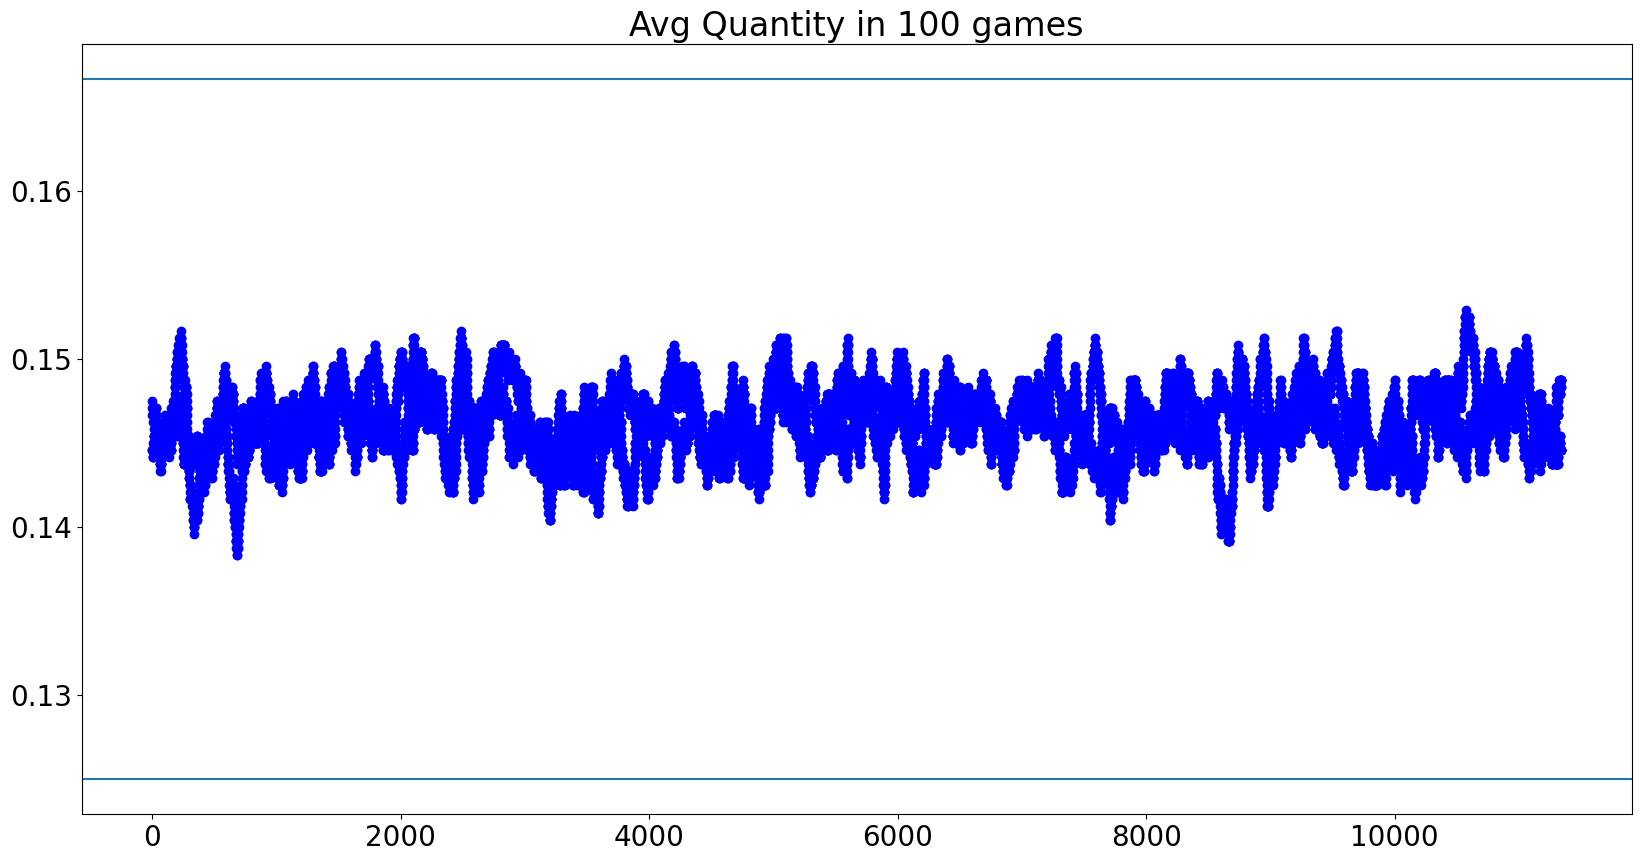

In [435]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.axhline(q1c)
plt.axhline(qm)
plt.plot(moving_average(np.array(agent1.action_history),100), label = 'Agent 1 Quantity', marker = 'o', c = 'b')
plt.plot(moving_average(np.array(agent2.action_history),100), label = 'Agent 2 Quantity', marker = 'o', c = 'b')
plt.title('Avg Quantity in 100 games') 
plt.show()

### Case 2: 1 RL Agent vs Copycat

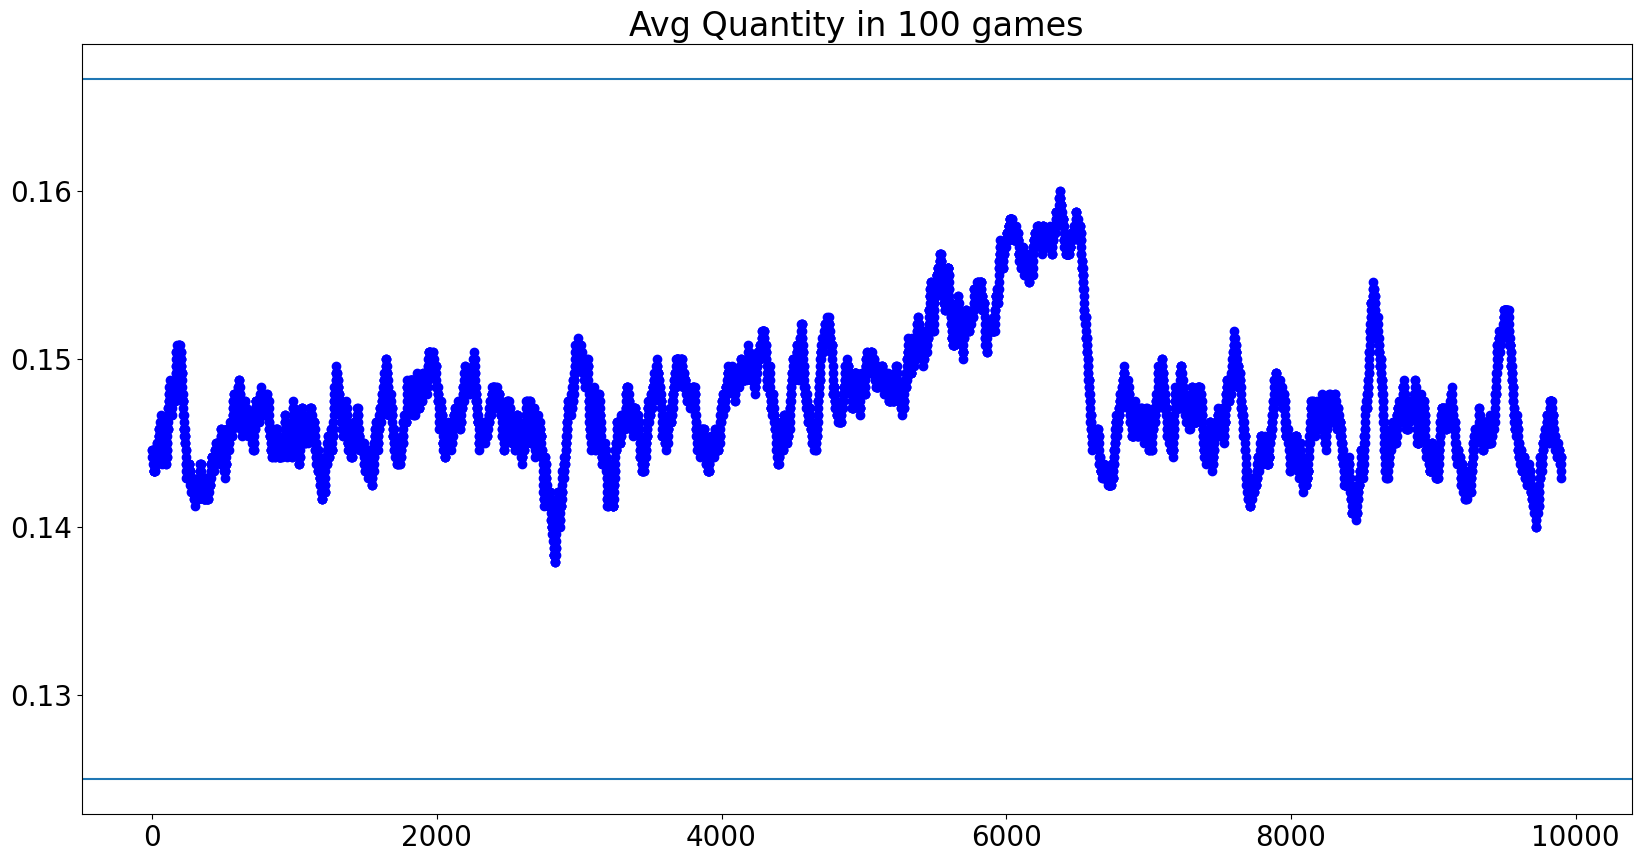

In [266]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.axhline(q2c)
plt.axhline(Qm/2)
plt.plot(moving_average(np.array(agent1.action_history),100), label = 'Agent 1 Quantity', marker = 'o', c = 'b')
plt.title('Avg Quantity in 100 games') 
plt.show()

### Case 3: 1 RL Agent (trained on copycat) vs itself